In [284]:
%matplotlib inline

In [285]:
import numpy as np
import pandas as pd
from scipy.stats import gmean

In [286]:
import matplotlib.pyplot as plt

In [287]:
import config
from utils.io import load_pickle
from utils.torch.datasets import PathologicalImagesDataset, PathologicalImagesDatasetMode
from utils.scoring import topcoder_metric
from predict import get_prediction_filename

# Load dataset

In [481]:
nb_folds = 5
fold_number = 0
models = ['unet', 'unet_low', ] # ['unet', 'tiramisu', 'unet_ds']
patch_size_train = 0
patch_size_predict = 0
use_dice = False
use_tta = False

In [482]:
threshold = 0.4

In [483]:
mode = PathologicalImagesDatasetMode.Val
base_dir = config.DATASET_TRAIN_DIR

In [484]:
dataset = PathologicalImagesDataset(base_dir, mode=mode, nb_folds=nb_folds, fold_number=fold_number)

In [485]:
images = [dataset[i][0] for i in range(len(dataset))]
masks = [dataset[i][1] for i in range(len(dataset))]

In [486]:
images = np.stack(images)
masks = np.stack(masks)

In [487]:
images.shape, masks.shape

((34, 500, 500, 3), (34, 500, 500))

# Load predictions 

In [488]:
predictions = []
for model in models:
    filename = get_prediction_filename(model, mode, patch_size_train, patch_size_predict,fold_number, use_dice, use_tta)
    _, model_predictions = load_pickle(filename)
    
    predictions.append(model_predictions)

In [489]:
[p.shape for p in predictions]

[(34, 500, 500), (34, 500, 500)]

In [490]:
# add mean predictions
predictions.append(gmean(predictions, axis=0))
models.append('gmean')

predictions.append(np.mean(predictions, axis=0))
models.append('mean')

In [491]:
[p.shape for p in predictions]

[(34, 500, 500), (34, 500, 500), (34, 500, 500), (34, 500, 500)]

In [492]:
predictions_masks = []
for model_predictions in predictions:
    model_predictions_mask = np.zeros_like(model_predictions)
    model_predictions_mask[model_predictions>threshold] = 1
    
    predictions_masks.append(model_predictions_mask)

# Plot predictions

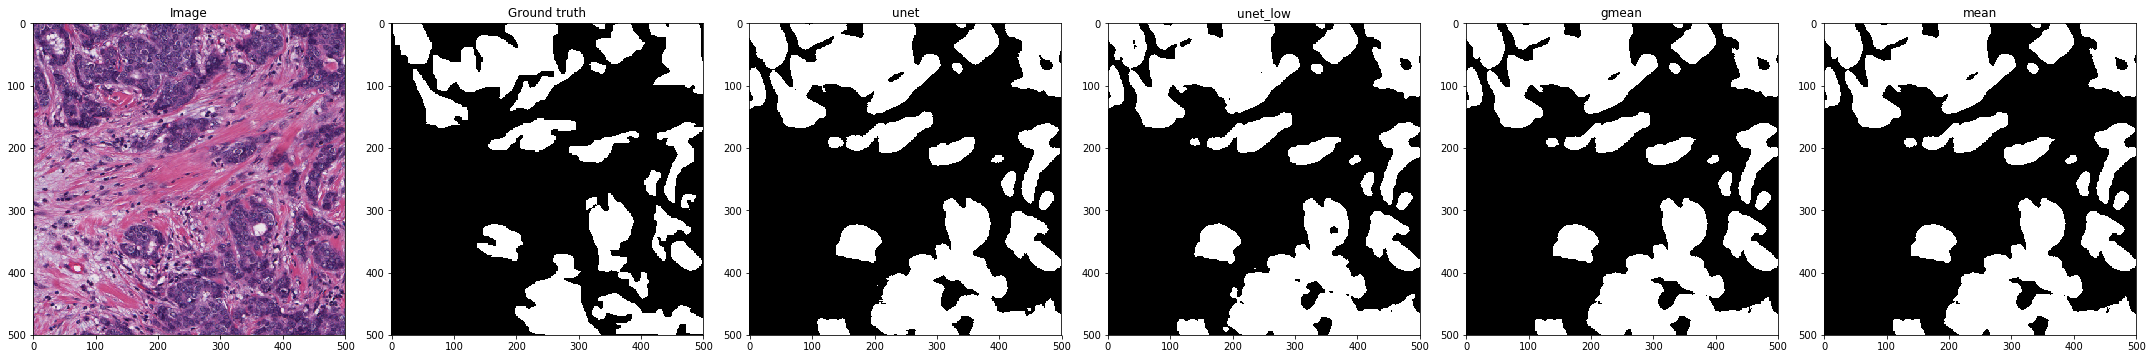

In [493]:
i = 4

fig, (ax_image, ax_groud_truth, *ax_models) = plt.subplots(1, 2 + len(models), figsize=(5 * (2 + len(models)),5))

ax_image.imshow(images[i])
ax_groud_truth.imshow(masks[i], cmap='gray')

ax_image.set_title('Image')
ax_groud_truth.set_title('Ground truth')

for ax, model, model_predictions in zip(ax_models, models, predictions_masks):
    ax.imshow(model_predictions[i], cmap='gray')
    ax.set_title(model)

fig.tight_layout()

# Get score

In [494]:
for model, model_predictions_masks in zip(models, predictions_masks):
    score = topcoder_metric(masks, model_predictions_masks)
    print(model, score)

unet 860729.685131
unet_low 848258.74918
gmean 856012.95847
mean 857089.549396


In [461]:
threshold_data = []
for model, model_predictions in zip(models, predictions):
    for tr in np.arange(0.1, 1.0, 0.1):
        predictions_mask = np.zeros_like(model_predictions)
        predictions_mask[model_predictions>tr] = 1

        score = topcoder_metric(masks, predictions_mask)

        threshold_data.append({'model':model, 'threshold': tr, 'score': score})

In [462]:
threshold_data = pd.DataFrame(threshold_data)

In [463]:
threshold_data

,model,score,threshold
0,unet,761143.558321,0.1
1,unet,808261.647157,0.2
2,unet,828054.513918,0.3
3,unet,832862.399579,0.4
4,unet,827380.989517,0.5
5,unet,813290.491980,0.6
6,unet,788771.898887,0.7
7,unet,739168.698710,0.8
8,unet,616167.416720,0.9
9,unet_ds_low,735617.351014,0.1


In [464]:
threshold_data.groupby('model').score.max()

model
gmean          833879.746335
mean           833540.875491
unet           832862.399579
unet_ds_low    819421.964839
Name: score, dtype: float64

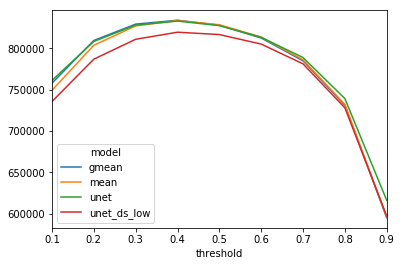

In [465]:
pd.pivot_table(threshold_data, values='score', columns='model', index='threshold').plot()

# Get scores

In [129]:
threshold = 0.3

In [130]:
mode = PathologicalImagesDatasetMode.Val
base_dir = config.DATASET_TRAIN_DIR
patch_size_train = 0
patch_size_predict = 0
nb_folds = 5

In [131]:
print(f'fold_number\tmodel\tuse_dice\tuse_tta\tscore')
for fold_number in range(nb_folds):
    dataset = PathologicalImagesDataset(base_dir, mode=mode, nb_folds=nb_folds, fold_number=fold_number)
    masks = [dataset[i][1] for i in range(len(dataset))]
    masks = np.stack(masks)

    for model in ['unet', 'tiramisu', 'unet_ds']:
        for use_tta in [True, False]:
            filename = get_prediction_filename(model, mode, patch_size_train, patch_size_predict,fold_number, use_dice, use_tta)
            _, model_predictions = load_pickle(filename)
            model_predictions_mask = np.zeros_like(model_predictions)
            model_predictions_mask[model_predictions>threshold] = 1

            score = topcoder_metric(masks, model_predictions_mask)

            print(f'{fold_number}\t{model}\t{use_dice}\t{use_tta}\t{score}')

fold_number	model	use_dice	use_tta	score
0	unet	False	True	861581.9453645087
0	unet	False	False	856388.075473714
0	tiramisu	False	True	841980.7054636072
0	tiramisu	False	False	841920.7000047597
0	unet_ds	False	True	854279.026733385
0	unet_ds	False	False	855376.8520917959
1	unet	False	True	828741.1650594576
1	unet	False	False	828054.5139181466
1	tiramisu	False	True	820495.5046021653
1	tiramisu	False	False	819549.0233527272
1	unet_ds	False	True	833747.1170278308
1	unet_ds	False	False	830254.3099317614
2	unet	False	True	880977.4456099011
2	unet	False	False	877221.8103921716
2	tiramisu	False	True	864623.2980515661
2	tiramisu	False	False	865309.7979030601
2	unet_ds	False	True	886243.1571359488
2	unet_ds	False	False	882444.1313373923
3	unet	False	True	841106.7541555531
3	unet	False	False	839104.0363780262
3	tiramisu	False	True	833891.7861838498
3	tiramisu	False	False	832344.7085590156
3	unet_ds	False	True	845708.4222841351
3	unet_ds	False	False	839556.8284105392
4	unet	False	True	835410.3440